In [244]:
#import dependencies 
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd

In [245]:
data_df=pd.read_csv("Data/HappinessAlcoholConsumption.csv")
data_df.head()

,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,Denmark,Western Europe,north,7.526,928,53.579,224,81,278
1,Switzerland,Western Europe,north,7.509,943,79.866,185,100,280
2,Iceland,Western Europe,north,7.501,933,60.530,233,61,78
3,Norway,Western Europe,north,7.498,951,70.890,169,71,129
4,Finland,Western Europe,north,7.413,918,43.433,263,133,97


# Dataframe Information


In [246]:
data_df = data_df.dropna()

In [247]:
#shape of dataframe
data_df.shape

(122, 9)

In [248]:
#unique regions
data_df["Region"].unique()

array(['Western Europe', 'North America', 'Australia and New Zealand',
       'Middle East and Northern Africa', 'Latin America and Caribbean',
       'Southeastern Asia', 'Central and Eastern Europe', 'Eastern Asia',
       'Sub-Saharan Africa'], dtype=object)

In [8]:
#unique countries
data_df["Country"].unique()

array(['Denmark', 'Switzerland', 'Iceland', 'Norway', 'Finland', 'Canada',
       'Netherlands', 'New Zealand', 'Australia', 'Sweden', 'Israel',
       'Austria', 'United States', 'Costa Rica', 'Germany', 'Brazil',
       'Belgium', 'Ireland', 'Luxembourg', 'Mexico', 'Singapore',
       'United Kingdom', 'Chile', 'Panama', 'Argentina', 'Czech Republic',
       'United Arab Emirates', 'Uruguay', 'Malta', 'Colombia', 'France',
       'Thailand', 'Qatar', 'Spain', 'Guatemala', 'Suriname', 'Bahrain',
       'Trinidad and Tobago', 'Venezuela', 'Slovakia', 'El Salvador',
       'Nicaragua', 'Uzbekistan', 'Italy', 'Ecuador', 'Belize', 'Japan',
       'Kazakhstan', 'Moldova', 'Russian Federation', 'Poland',
       'South Korea', 'Bolivia', 'Lithuania', 'Belarus', 'Slovenia',
       'Peru', 'Turkmenistan', 'Mauritius', 'Latvia', 'Cyprus',
       'Paraguay', 'Romania', 'Estonia', 'Jamaica', 'Croatia', 'Turkey',
       'Jordan', 'Azerbaijan', 'Philippines', 'China', 'Kyrgyzstan',
       'Serbia',

In [249]:
data_df.columns

Index(['Country', 'Region', 'Hemisphere', 'HappinessScore', 'HDI',
       'GDP_PerCapita', 'Beer_PerCapita', 'Spirit_PerCapita',
       'Wine_PerCapita'],
      dtype='object')

# Importing Population Data
for use in averaging GDP per capita

In [264]:
pop_data = pd.read_csv("Data/Population Data/Global Population Trends(2016-2022).csv")
pop_data_2018 = pop_data.loc[pop_data["Year"] == 2018, ["Country", "Total Population"]]
pop_data_2018

,Country,Total Population
1,Afghanistan,"36,686,784"
6,Albania,"2,866,376"
11,Algeria,"41,927,007"
15,American Samoa,"48,424"
19,Andorra,"75,013"
...,...,...
1049,Virgin Islands (U.S.),"107,001"
1054,West Bank And Gaza,"4,569,087"
1059,Yemen,"30,790,513"
1064,Zambia,"17,835,893"


In [275]:
merged_data = pd.merge(pop_data_2018, data_df, how = "inner", on = "Country")
merged_data

,Country,Total Population,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,Albania,"2,866,376",Central and Eastern Europe,north,4.655,782,4.132,89,132,54
1,Angola,"31,273,533",Sub-Saharan Africa,south,3.866,577,3.309,217,57,45
2,Argentina,"44,494,502",Latin America and Caribbean,south,6.650,822,12.654,193,25,221
3,Armenia,"2,836,557",Central and Eastern Europe,north,4.360,749,3.606,21,179,11
4,Australia,"24,966,643",Australia and New Zealand,south,7.313,938,49.897,261,72,212
...,...,...,...,...,...,...,...,...,...,...
106,Uzbekistan,"32,956,100",Central and Eastern Europe,north,5.987,703,2.106,25,101,8
107,Venezuela,"29,825,653",Latin America and Caribbean,north,6.084,766,15.692,333,100,3
108,Vietnam,"94,914,330",Southeastern Asia,north,5.061,689,2.171,111,2,1
109,Zambia,"17,835,893",Sub-Saharan Africa,south,4.795,586,1.263,32,19,4


# GDP Analysis
first by regional averages, then by country

In [298]:
#GDP not per capita (multiply GDP times population of each country)
#GDP per nation

# Convert 'GDP_PerCapita' column to numeric

merged_data['GDP_PerCapita'] = pd.to_numeric(merged_data['GDP_PerCapita'], errors='coerce')

# Create a new column 'Regular_GDP' in gdp_df by multiplying 'GDP_PerCapita' and 'Total Population'
# Check for NaN values in 'GDP_PerCapita' and 'Total Population' columns
nan_check = merged_data[['GDP_PerCapita', 'Total Population']].isna().any()

if nan_check.any():
    print("Warning: NaN values detected in the columns. Please handle or remove them.")
else:
    # Create a new column 'Regular_GDP' by multiplying 'GDP_PerCapita' and 'Total Population'
    merged_data['Regular_GDP'] = merged_data['GDP_PerCapita'] * merged_data['Total Population']


In [299]:
print(merged_data[['Country', 'Total Population', 'Region', 'GDP_PerCapita', 'Regular_GDP']])


        Country  Total Population                       Region  GDP_PerCapita  \
0       Albania           2866376   Central and Eastern Europe          4.132   
1        Angola          31273533           Sub-Saharan Africa          3.309   
2     Argentina          44494502  Latin America and Caribbean         12.654   
3       Armenia           2836557   Central and Eastern Europe          3.606   
4     Australia          24966643    Australia and New Zealand         49.897   
..          ...               ...                          ...            ...   
106  Uzbekistan          32956100   Central and Eastern Europe          2.106   
107   Venezuela          29825653  Latin America and Caribbean         15.692   
108     Vietnam          94914330            Southeastern Asia          2.171   
109      Zambia          17835893           Sub-Saharan Africa          1.263   
110    Zimbabwe          15052184           Sub-Saharan Africa          1.029   

      Regular_GDP  
0    1.

In [290]:
#Analysing GDP
gdp_df=merged_data[['Country', 'Total Population', 'Region', 'GDP_PerCapita', 'Regular_GDP']]
gdp_df

,Country,Total Population,Region,GDP_PerCapita,Regular_GDP
0,Albania,2866376,Central and Eastern Europe,4.132,1.184387e+07
1,Angola,31273533,Sub-Saharan Africa,3.309,1.034841e+08
2,Argentina,44494502,Latin America and Caribbean,12.654,5.630334e+08
3,Armenia,2836557,Central and Eastern Europe,3.606,1.022862e+07
4,Australia,24966643,Australia and New Zealand,49.897,1.245761e+09
...,...,...,...,...,...
106,Uzbekistan,32956100,Central and Eastern Europe,2.106,6.940555e+07
107,Venezuela,29825653,Latin America and Caribbean,15.692,4.680241e+08
108,Vietnam,94914330,Southeastern Asia,2.171,2.060590e+08
109,Zambia,17835893,Sub-Saharan Africa,1.263,2.252673e+07


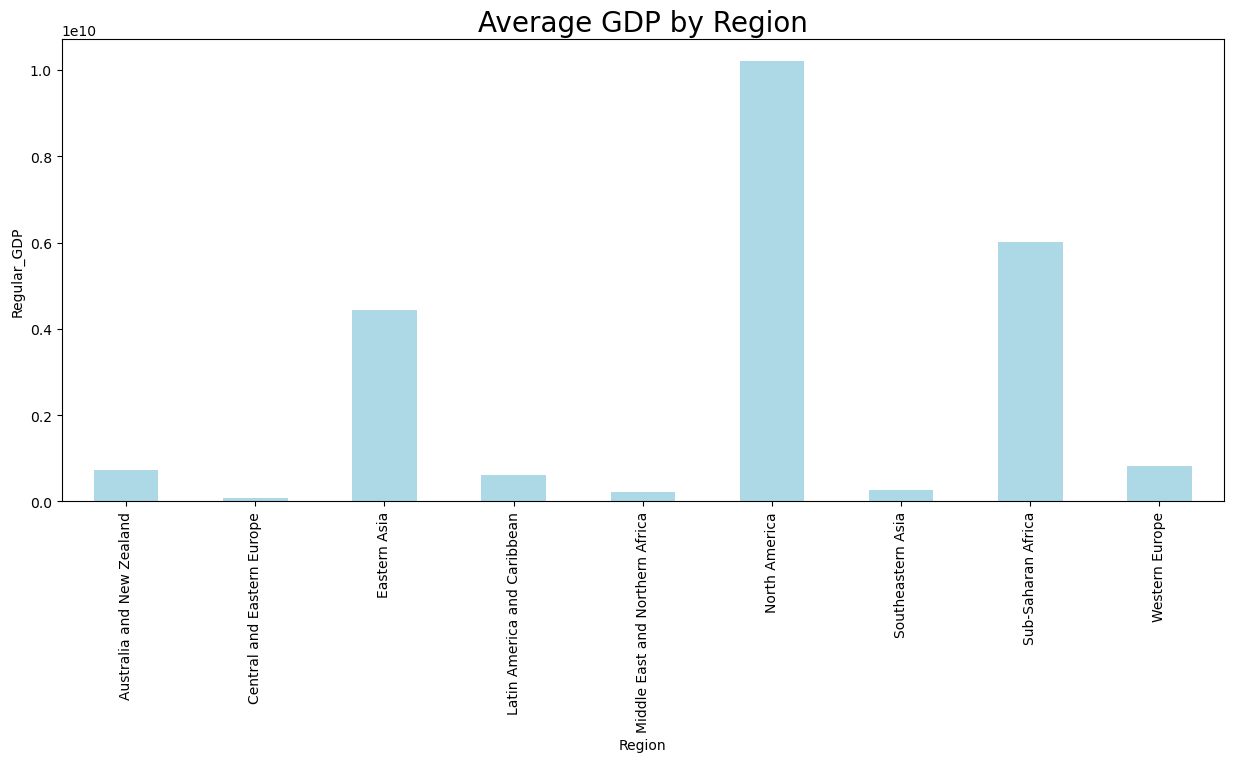

In [300]:
#Average GDP by Region
plt.figure(figsize=(15, 6))
gdp_df.groupby('Region')['Regular_GDP'].mean().plot(kind='bar', color='lightblue')
plt.title('Average GDP by Region', fontsize=20)
plt.xlabel('Region')
plt.ylabel('Regular_GDP')
plt.xticks(rotation=90)
plt.show()

Text(0, 0.5, 'GDP')

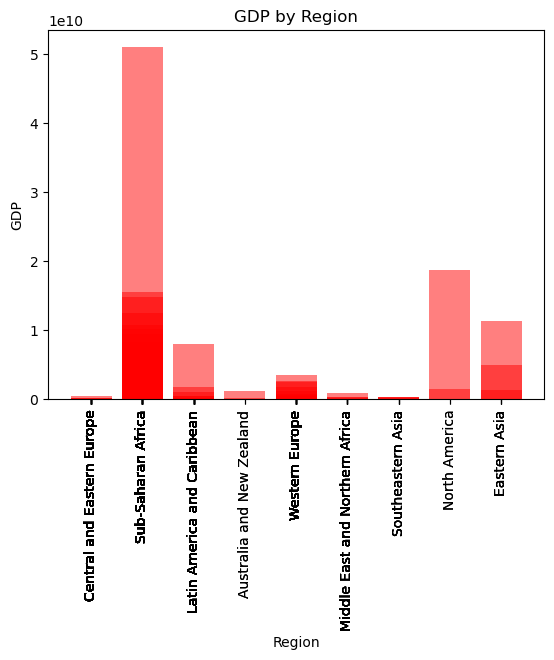

In [301]:
#chart for GDP by Region
gdp=gdp_df["Regular_GDP"]
region=gdp_df["Region"]

plt.bar(region,gdp,color="r",alpha=0.5,align="center")
tick_loactions=[value for value in region]
plt.xticks(tick_loactions,region,rotation=90)

plt.title("GDP by Region")
plt.xlabel("Region")
plt.ylabel("GDP")


In [302]:
#top 20 GDP countries
gdp=gdp_df.sort_values(["Regular_GDP"],ascending=False)
gdp.head(25)

,Country,Total Population,Region,GDP_PerCapita,Regular_GDP
96,Tanzania,58090443,Sub-Saharan Africa,878.000,5.100341e+10
104,United States,326838199,North America,57.589,1.882229e+10
62,Mali,19934298,Sub-Saharan Africa,780.000,1.554875e+10
85,Senegal,15574909,Sub-Saharan Africa,953.000,1.484289e+10
16,Burkina Faso,20392723,Sub-Saharan Africa,614.000,1.252113e+10
22,China,1402760000,Eastern Asia,8.117,1.138620e+10
60,Madagascar,26846541,Sub-Saharan Africa,402.000,1.079231e+10
20,Chad,15604210,Sub-Saharan Africa,651.000,1.015834e+10
11,Benin,11940683,Sub-Saharan Africa,789.000,9.421199e+09
74,Niger,22577058,Sub-Saharan Africa,368.000,8.308357e+09


<Figure size 1500x1000 with 0 Axes>

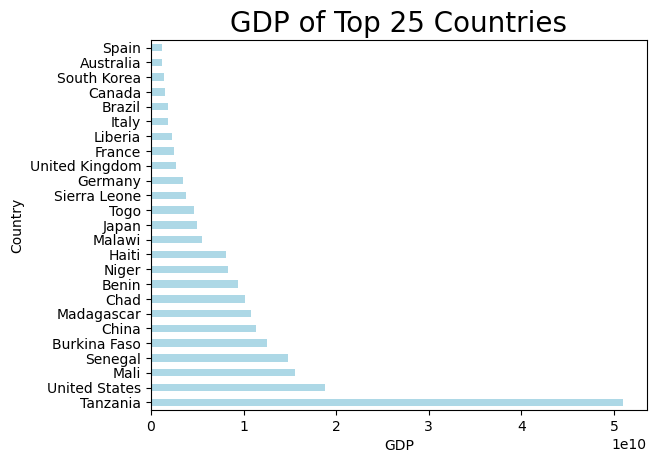

In [303]:
#chart top 25 countries by GDP
gdp=gdp_df["Regular_GDP"]
country=gdp_df["Country"]

plt.figure(figsize=(15, 10))
top_25_countries = gdp_df.nlargest(25, 'Regular_GDP')
top_25_countries.plot(kind='barh', x='Country', y='Regular_GDP', color='lightblue', legend=False)
plt.title('GDP of Top 25 Countries', fontsize=20)
plt.xlabel('GDP')
plt.ylabel('Country')
plt.show()


In [296]:
#bottom 25 GDP countries
gdp=gdp_df.sort_values(["Regular_GDP"],ascending=True)
gdp.head(25)

,Country,Total Population,Region,GDP_PerCapita,Regular_GDP
10,Belize,382066,Latin America and Caribbean,4.960,1.895047e+06
93,Suriname,593715,Latin America and Caribbean,5.871,3.485701e+06
68,Montenegro,622227,Central and Eastern Europe,7.029,4.373634e+06
66,Moldova,2707203,Central and Eastern Europe,1.913,5.178879e+06
3,Armenia,2836557,Central and Eastern Europe,3.606,1.022862e+07
70,Namibia,2405680,Sub-Saharan Africa,4.561,1.097231e+07
67,Mongolia,3163991,Eastern Asia,3.694,1.168778e+07
0,Albania,2866376,Central and Eastern Europe,4.132,1.184387e+07
63,Malta,484630,Western Europe,24.771,1.200477e+07
64,Mauritius,1265577,Sub-Saharan Africa,9.682,1.225332e+07


<Figure size 1500x1000 with 0 Axes>

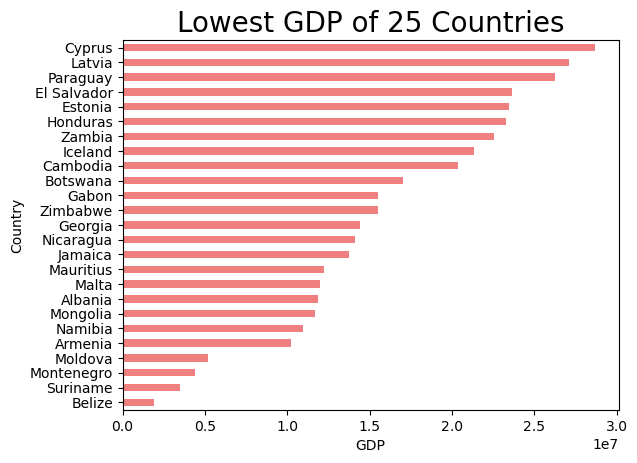

In [297]:
#Bottom 25 countries by GDP
plt.figure(figsize=(15, 10))
smallest_25_countries = gdp_df.nsmallest(25, 'Regular_GDP')
smallest_25_countries.plot(kind='barh', x='Country', y='Regular_GDP', color='lightcoral', legend=False)
plt.title('Lowest GDP of 25 Countries', fontsize=20)
plt.xlabel('GDP')
plt.ylabel('Country')
plt.show()

# Human Deveolpment Index (HDI)
first by regional averages, then by country

In [304]:
#Analysing for HDI by Region
hdi_df=data_df[["Country","Region","HDI"]].copy()
hdi_df

,Country,Region,HDI
0,Denmark,Western Europe,928
1,Switzerland,Western Europe,943
2,Iceland,Western Europe,933
3,Norway,Western Europe,951
4,Finland,Western Europe,918
...,...,...,...
117,Tanzania,Sub-Saharan Africa,533
118,Liberia,Sub-Saharan Africa,432
119,Benin,Sub-Saharan Africa,512
120,Togo,Sub-Saharan Africa,500


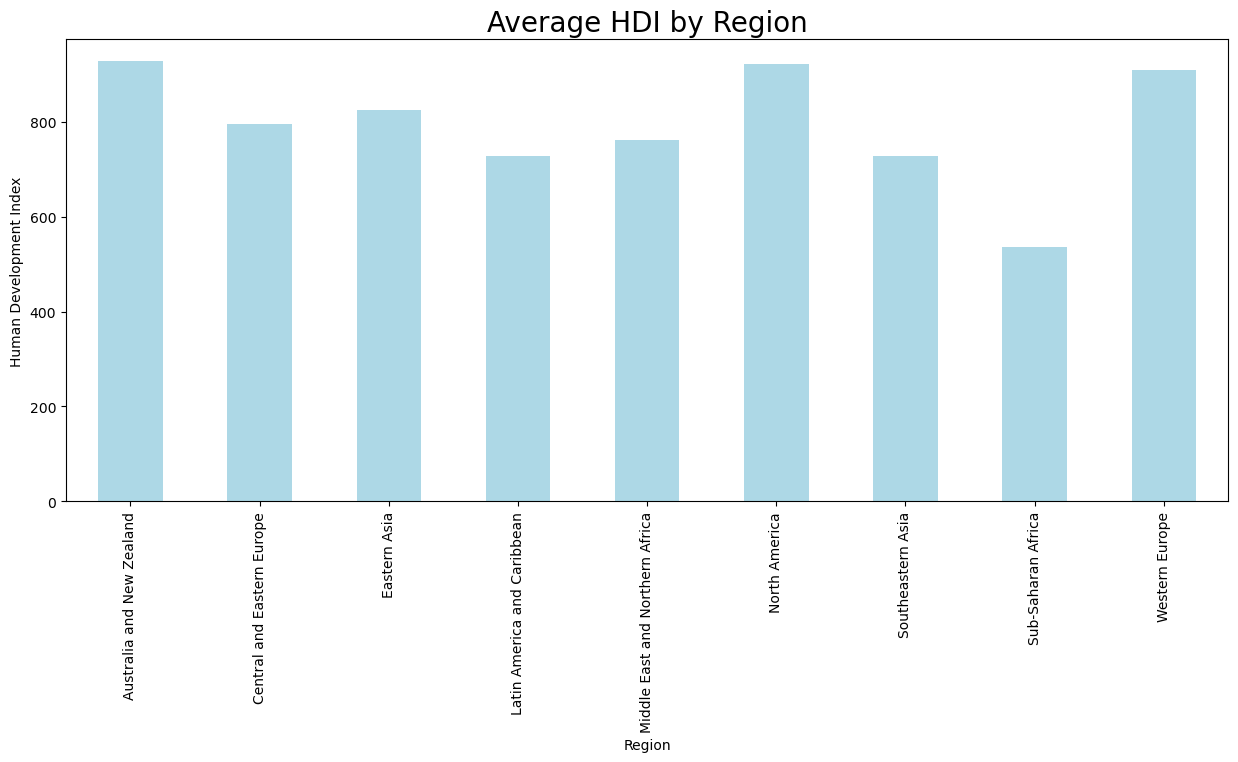

In [305]:
#average HDI per region
plt.figure(figsize=(15, 6))
hdi_df.groupby('Region')['HDI'].mean().plot(kind='bar', color='lightblue')
plt.title('Average HDI by Region', fontsize=20)
plt.xlabel('Region')
plt.ylabel('Human Development Index')
plt.xticks(rotation=90)
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (111,) and arg 1 with shape (122,).

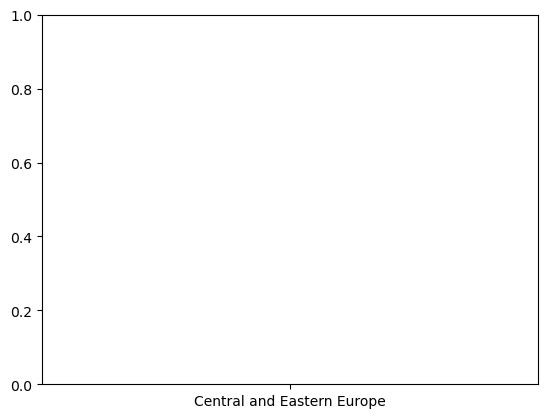

In [306]:
#HDI per region
hdi=hdi_df["HDI"]
region=gdp_df["Region"]

plt.bar(region,hdi,color="r",alpha=0.5,align="center")
tick_loactions=[value for value in region]
plt.xticks(tick_loactions,region,rotation=90)

plt.title("HDI by Region")
plt.xlabel("Region")
plt.ylabel("Human Development Index")

In [307]:
#Top 25 HDI Countries
hdi=hdi_df.sort_values(["HDI"],ascending=False)
hdi.head(25)

,Country,Region,HDI
3,Norway,Western Europe,951
1,Switzerland,Western Europe,943
8,Australia,Australia and New Zealand,938
14,Germany,Western Europe,934
17,Ireland,Western Europe,934
2,Iceland,Western Europe,933
9,Sweden,Western Europe,932
20,Singapore,Southeastern Asia,930
0,Denmark,Western Europe,928
6,Netherlands,Western Europe,928


<Figure size 1500x1000 with 0 Axes>

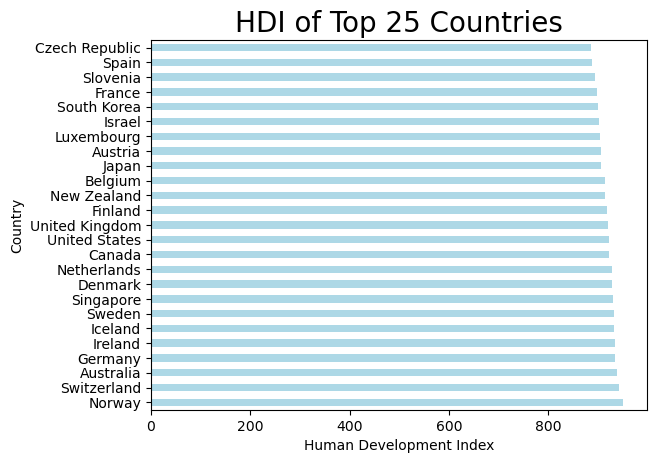

In [308]:
#Top 25 HDI Countries Graph
hdi=hdi_df["HDI"]
country=hdi_df["Country"]

plt.figure(figsize=(15, 10))
top_25_countries = hdi_df.nlargest(25, 'HDI')
top_25_countries.plot(kind='barh', x='Country', y='HDI', color='lightblue', legend=False)
plt.title('HDI of Top 25 Countries', fontsize=20)
plt.xlabel('Human Development Index')
plt.ylabel('Country')
plt.show()


In [309]:
#bottom 25 HDI Countries
hdi=hdi_df.sort_values(["HDI"],ascending=True)
hdi.head(25)

,Country,Region,HDI
113,Niger,Sub-Saharan Africa,351
114,Chad,Sub-Saharan Africa,405
89,Sierra Leone,Sub-Saharan Africa,413
115,Burkina Faso,Sub-Saharan Africa,420
106,Mali,Sub-Saharan Africa,421
118,Liberia,Sub-Saharan Africa,432
98,Dem. Rep. Congo,Sub-Saharan Africa,452
104,Malawi,Sub-Saharan Africa,474
110,Cote d'Ivoire,Sub-Saharan Africa,486
107,Haiti,Latin America and Caribbean,496


<Figure size 1500x1000 with 0 Axes>

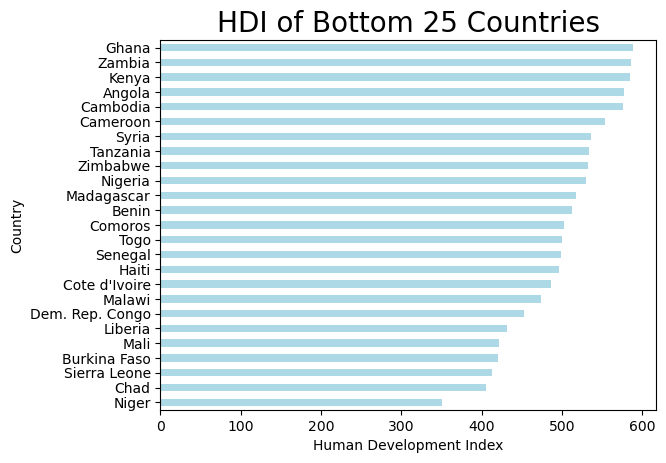

In [310]:
#bottom 25 HDI Countries
hdi=hdi_df["HDI"]
country=hdi_df["Country"]

plt.figure(figsize=(15, 10))
top_25_countries = hdi_df.nsmallest(25, 'HDI')
top_25_countries.plot(kind='barh', x='Country', y='HDI', color='lightblue', legend=False)
plt.title('HDI of Bottom 25 Countries', fontsize=20)
plt.xlabel('Human Development Index')
plt.ylabel('Country')
plt.show()


## Next Section